In [2]:
%load_ext autoreload
%autoreload 2

from typing import *
from math import log2
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import theoretical_models as M

matplotlib.rcParams.update({"legend.frameon": False, "axes.spines.right": False, "axes.spines.top": False})

In [3]:
method_to_name = {
    'approx_topk.torch_default.topk': "default",
    'approx_topk.torch_default.bucket_topk': "bucket",
    'approx_topk.bucket_argmax.topk_torch': "argmax",
    'approx_topk.priority_queue.topk': "custom",
}
index = ["batch_size", "topk_size", "k", "j", "k_mult"]

df = (pd.concat([pd.read_json(f, lines=True) for f in Path("../data/generic").glob("*.jsonl")])
    .reset_index(drop=True)
    .pipe(lambda d: d.assign(
        method=d.method.apply(method_to_name.__getitem__),
        duration=d.duration.apply(np.mean) / d.n_inner,
        duration_stderr=d.duration.apply(lambda d: np.std(d)/np.sqrt(len(d))) / d.n_inner,
    ))
    .pipe(lambda d: d.assign(
        bandwidth=d.dtype.apply(dict(float32=4, float16=2).__getitem__) * d.topk_size * d.batch_size / d.duration,
    ))
    .pipe(lambda d: d[d.compile.isna() | (d.method == "argmax")])
    .drop(columns=["args", "compile", "cuda_graphs", "n_warmup", "n_outer", "n_inner", "n_inner_inputs", "dtype", "device"])
)

dfm = (pd.read_json("../data/theoretical_models.jsonl", lines=True)
    .rename(columns=dict(k_b="j", m="batch_size", n="topk_size"))
    .pipe(lambda d: d.assign(
        k_mult=((d.j*d.b)/d.k).fillna(1).astype(int),
        j=d.j.fillna(d.k).astype(int),
    ))
    .drop(columns=["algorithm", "recall_simulation_n", "recall_simulation_std", "b"])
)
m = 256
dfm = pd.concat([dfm, dfm.pipe(lambda d: d.assign(batch_size=m, cost_basic=d.cost_basic*m, cost_serial=d.cost_serial*m))]).reset_index(drop=True)
df = df.set_index(index + ["method"]).join(dfm.set_index(index), how="inner").reset_index()

print(len(df))
print(df.method.unique())
df.head()

1968
['bucket' 'argmax' 'custom' 'default']


,batch_size,topk_size,k,j,k_mult,method,duration,duration_stderr,bandwidth,recall_model,recall_simulation,cost_basic,cost_serial,cost_hybrid,cost_parallel
0,1,4096,1,1,1,bucket,0.000029,9.537275e-08,2.780425e+08,1.0,1.0,4096,8192,8192,27
1,1,4096,1,1,2,bucket,0.000030,6.234413e-08,2.686023e+08,1.0,1.0,4098,8196,4100,30
2,1,4096,1,1,4,bucket,0.000028,4.249003e-08,2.911799e+08,1.0,1.0,4100,8200,2056,30
3,1,4096,1,1,8,bucket,0.000025,3.264928e-08,3.277808e+08,1.0,1.0,4104,8208,1040,30
4,1,4096,1,1,16,bucket,0.000023,2.552206e-08,3.493148e+08,1.0,1.0,4112,8224,544,30


# Comparing cost models

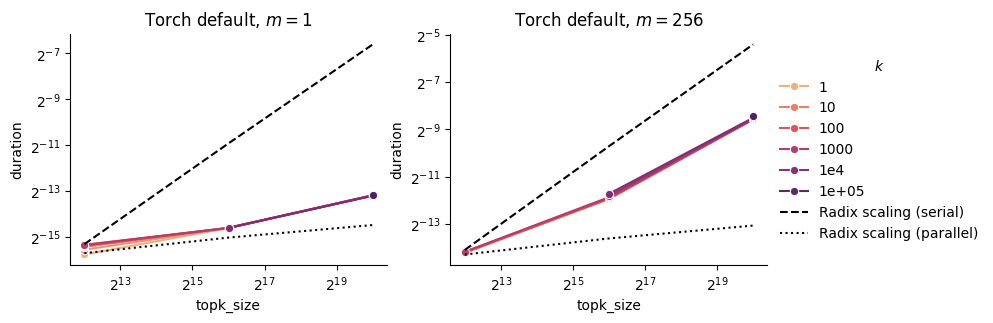

In [4]:
_, axs = plt.subplots(ncols=2, nrows=1, figsize=(9, 3))
for batch_size, ax in zip([1, 256], axs):
    d = df[(df.batch_size==batch_size) & (df.method=="default")]
    xs = d.topk_size.unique()
    sns.lineplot(data=d, y="duration", x="topk_size", hue="k", hue_norm=matplotlib.colors.LogNorm(),
                 markers=True, marker="o", palette="flare", ax=ax)
    s0, s1 = (33, 24.6) if batch_size == 1 else (31.8, 23.2)
    ax.plot(xs, [M.cost_serial.radix(k=1, n=x, m=1)/2**s0 for x in xs], "k--", label="Radix scaling (serial)")
    ax.plot(xs, [M.cost_parallel.radix(k=1, n=x, m=1)/2**s1 for x in xs], "k:", label="Radix scaling (parallel)")
    if ax is axs[-1]:
        ax.legend(title="$k$", loc="center left", bbox_to_anchor=(1, 0.5))
    else:
        ax.legend_.remove()
    ax.set_xscale("log", base=2)
    ax.set_yscale("log", base=2)
    ax.set_title(f"Torch default, $m={batch_size}$")

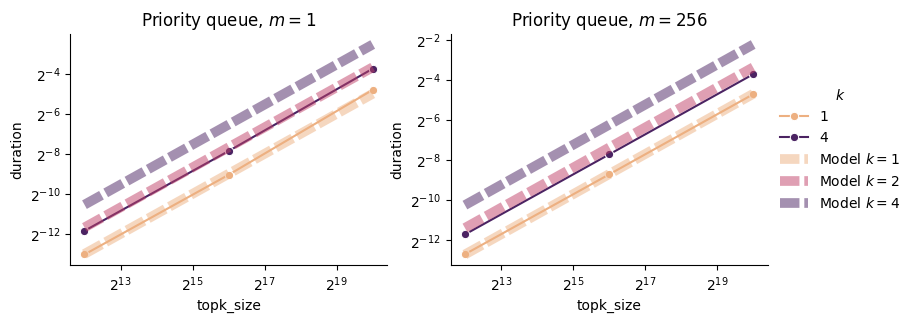

In [5]:
norm = matplotlib.colors.LogNorm(vmin=1, vmax=4)
palette = sns.color_palette("flare", as_cmap=True)
_, axs = plt.subplots(ncols=2, nrows=1, figsize=(9, 3))
for batch_size, ax in zip([1, 256], axs):
    sns.lineplot(data=df[(df.k == df.j) & (df.k_mult == 1) & (df.method == "custom") & (df.batch_size == batch_size)],
                 y="duration", x="topk_size", hue="k", hue_norm=norm, palette=palette, markers=True, marker="o", ax=ax)
    for k in [1, 2, 4]:
        s = 26 if batch_size==1 else 25.7
        ax.plot(xs, [M.cost_serial.insertion(k=k, n=x, m=1)/2**s for x in xs],
                color=palette(norm(k)), ls="--", lw=7, dashes=(2, 0.5), alpha=.5, label=f"Model $k={k}$")
    ax.set_xscale("log", base=2)
    ax.set_yscale("log", base=2)
    if ax is axs[-1]:
        ax.legend(title="$k$", loc="center left", bbox_to_anchor=(1, 0.5))
    else:
        ax.legend_.remove()
    ax.set_title(f"Priority queue, $m={batch_size}$")

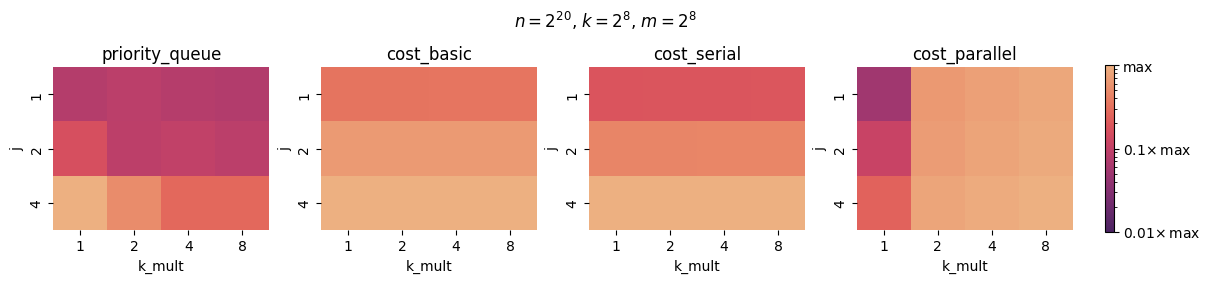

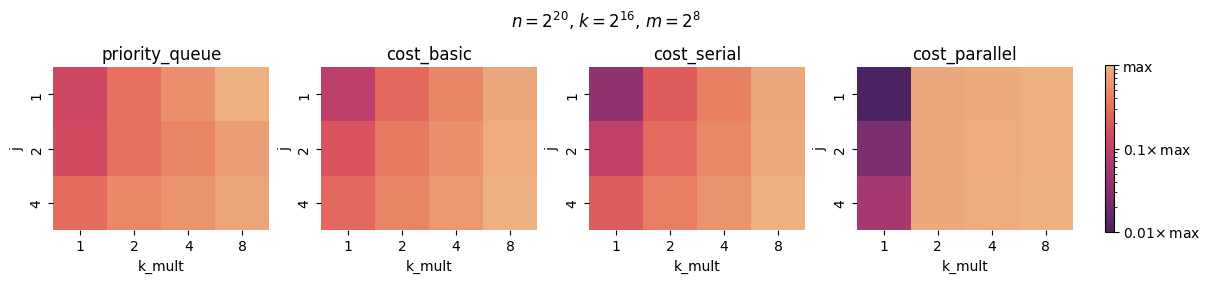

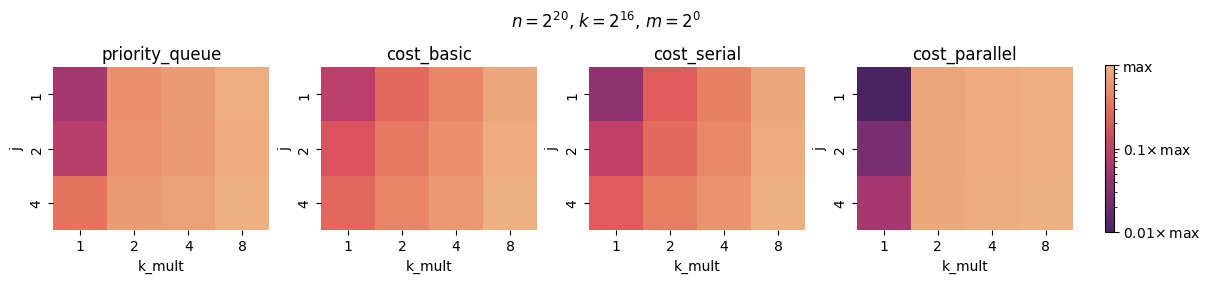

In [120]:
cost_models = ["cost_basic", "cost_serial", "cost_parallel"]
for topk_size, k, batch_size in [(1048576, 256, 256), (1048576, 65536, 256), (1048576, 65536, 1)]:
    d = df[(df.topk_size == topk_size) & (df.k == k) & (df.method == "custom") & (df.batch_size == batch_size) & (df.k_mult <= 8)]
    fig, axs = plt.subplots(ncols=1+len(cost_models), figsize=((1+len(cost_models))*3, 2.5), layout="constrained")
    sns.heatmap(d.pivot(index="j", columns="k_mult", values="duration"),
                norm=matplotlib.colors.LogNorm(d.duration.max()/100, d.duration.max()),
                cmap="flare_r", ax=axs[0], cbar=False, square=True)
    axs[0].set_title("priority_queue")
    for cost, ax in zip(cost_models, axs[1:]):
        sns.heatmap(d.pivot(index="j", columns="k_mult", values=cost),
                    norm=matplotlib.colors.LogNorm(d[cost].max()/100, d[cost].max()),
                    cmap="flare_r", ax=ax, cbar=False, square=True)
        ax.set_title(cost)
    cbar = plt.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.LogNorm(1/100, 1), cmap="flare_r"), ax=axs[-1], shrink=0.85, pad=0.15)
    cbar.set_ticks([1/100, 1/10, 1])
    cbar.set_ticklabels(["max" if x == 1 else f"${x}\\!\\times \\mathrm{{max}}$" for x in cbar.get_ticks()])
    fig.suptitle(f"$n=2^{{{np.log2(topk_size):.0f}}}$, $k=2^{{{np.log2(k):.0f}}}$, $m=2^{{{np.log2(batch_size):.0f}}}$", y=1.1);

# Trade-off

In [298]:
d = df.groupby(["batch_size", "topk_size", "k"]).apply(lambda d: d.assign(speedup=d.duration[d.method=="default"].iloc[0]/d.duration), include_groups=False).reset_index().drop(columns="level_3")
d.sort_values("speedup", ascending=False)[:10]

,batch_size,topk_size,k,j,k_mult,method,duration,duration_stderr,bandwidth,recall_model,recall_simulation,cost_basic,cost_serial,cost_hybrid,cost_parallel,speedup
976,1,1048576,262144,1,1,argmax,0.000004,5.292415e-09,4.946332e+11,0.632121,0.683662,1048576,2097152,8,7,25.402362
536,1,65536,16384,1,1,argmax,0.000002,2.815275e-09,6.473490e+10,0.632132,0.683420,65536,131072,8,7,19.961662
951,1,1048576,65536,1,1,custom,0.000006,3.461237e-09,3.597829e+11,0.632123,0.644084,1048576,2097152,32,11,18.493529
979,1,1048576,262144,2,1,custom,0.000007,3.965542e-09,3.190373e+11,0.729330,0.766569,2097152,5242880,40,18,16.384468
537,1,65536,16384,1,1,custom,0.000003,2.710657e-09,5.222512e+10,0.632132,0.683420,65536,131072,8,7,16.104144
510,1,65536,4096,1,1,argmax,0.000003,2.863044e-09,5.070116e+10,0.632165,0.643845,65536,131072,32,11,15.666852
466,1,65536,1024,1,1,argmax,0.000003,3.615293e-09,4.688678e+10,0.632300,0.637314,65536,131072,128,15,14.454324
539,1,65536,16384,2,1,custom,0.000003,3.720192e-09,4.426986e+10,0.729346,0.765895,131072,327680,40,18,13.651060
977,1,1048576,262144,1,1,custom,0.000008,3.607969e-09,2.607162e+11,0.632121,0.683662,1048576,2097152,8,7,13.389329
1192,256,4096,1024,1,1,argmax,0.000004,4.421964e-09,4.905475e+11,0.632300,0.683136,1048576,2097152,8,7,12.610728


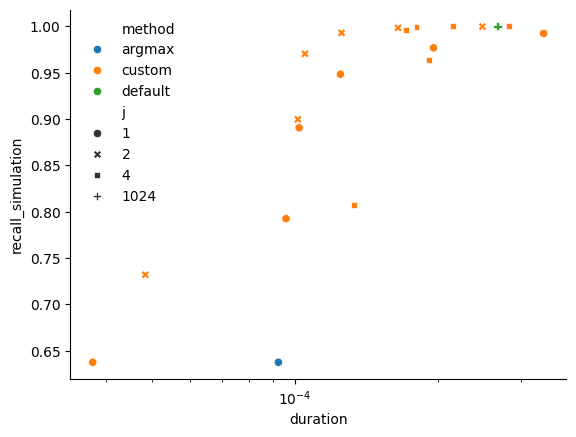

In [479]:
d = df[(df.batch_size==256) & (df.topk_size == 65536) & (df.k == 1024) & (df.method != "bucket")]
ax = sns.scatterplot(data=d, y="recall_simulation", x="duration", hue="method", style="j")
ax.set_xscale("log")

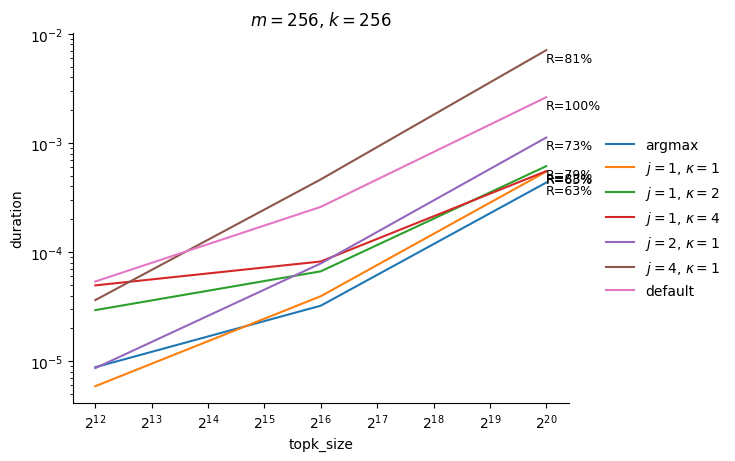

In [360]:
batch_size, k = 256, 256
d = (df[(df.batch_size == batch_size) & (df.k == k) & (df.method != "bucket") & ((df.method != "custom") | ((df.j <= 4) & (df.k_mult == 1)) | ((df.j == 1) & (df.k_mult <= 4)))]
     .assign(name=df.apply(lambda s: f"$j={s.j}$, $\kappa={s.k_mult}$" if s.method == "custom" else s.method, axis=1)))
# display(d)
ax = sns.lineplot(data=d, y="duration", x="topk_size", hue="name")
for _, s in d[d.topk_size==d.topk_size.max()].iterrows():
    ax.annotate(f"R={s.recall_simulation:.0%}", [s.topk_size, s.duration],
                xytext=(0, -1), textcoords="offset points", va="top", ha="left", fontsize=9)
ax.set_title(f"$m={batch_size}$, $k={k}$")
ax.set_xscale("log", base=2)
ax.set_yscale("log")
ax.legend(loc="center left", bbox_to_anchor=(1.05, 0.5));

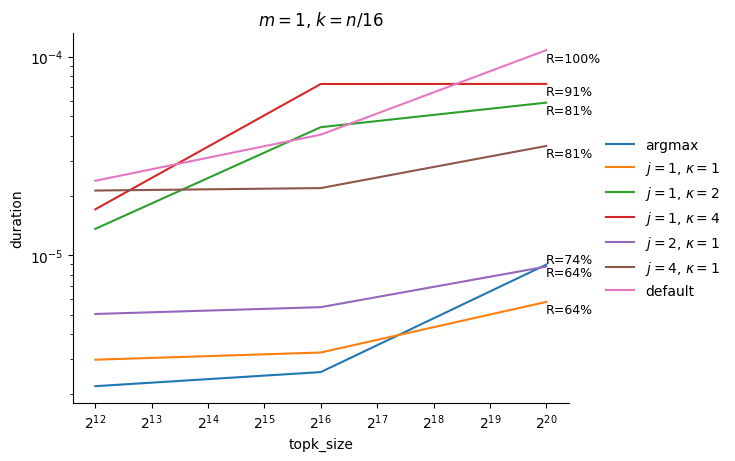

In [359]:
batch_size, k_ratio = 1, 16
d = (df[(df.batch_size == batch_size) & (df.topk_size//df.k == k_ratio) & (df.method != "bucket") & ((df.method != "custom") | ((df.j <= 4) & (df.k_mult == 1)) | ((df.j == 1) & (df.k_mult <= 4)))]
     .assign(name=df.apply(lambda s: f"$j={s.j}$, $\kappa={s.k_mult}$" if s.method == "custom" else s.method, axis=1)))
# display(d)
ax = sns.lineplot(data=d, y="duration", x="topk_size", hue="name")
for _, s in d[d.topk_size==d.topk_size.max()].iterrows():
    offset = +10 if s["name"] == "$j=2$, $\kappa=1$" else -1
    ax.annotate(f"R={s.recall_simulation:.0%}", [s.topk_size, s.duration],
                xytext=(0, offset), textcoords="offset points", va="top", ha="left", fontsize=9)
ax.set_title(f"$m={batch_size}$, $k=n/{k_ratio}$")
ax.set_xscale("log", base=2)
ax.set_yscale("log")
ax.legend(loc="center left", bbox_to_anchor=(1.05, 0.5));